In [3]:
#!pip install pyyaml==5.1
#!pip uninstall torch -y
#!pip install torch==1.10.0 torchvisio torchaudio
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.12 ; cuda:  cu113
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.12/index.html
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 40.1 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
# Some basic setup:
# Setup detectron2 logger
#import cv2
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
print("test")


test


### !conda install tensorflow-gpu=2.3 tensorflow=2.3=mkl_py38h1fcfbd6_0

In [12]:
#Split dataset into train and validation with a 90/10 ratio.
import shutil
import os
import random
from os.path import exists
train = [f for f in os.listdir('./annotations')]
val = []
print(len(train))

for file in train:
    if os.path.isdir(file):
        train.remove(file)


while len(val) <= len(train)*0.1:
    annofile = (random.choice(train))
    specfile = annofile.split(".")[0]+".png"
    if exists("./spectrogram/"+specfile):
        shutil.move("./annotations/"+annofile, "./annotations/val/"+annofile)
        shutil.move("./spectrogram/"+specfile, "./spectrogram/val/"+specfile)
        val.append(annofile)
        train.remove(annofile)
    else:
        shutil.move("./annotations/"+annofile, "./annotations/quarantine/"+annofile)
        train.remove(annofile)

533


In [2]:
#Function to register dataset catalog by linking images to their corresponding bounding boxes.
from detectron2.structures import BoxMode
import glob

def get_annos(annos_dir,img_dir):
    dataset_dicts = []

    os.chdir(annos_dir)
    print(os.getcwd())

    for file in glob.glob("*.txt"):
        df = pd.read_csv(os.path.join(annos_dir,file),sep="-", dtype=str)
#        print(file)
        gtvalues=[]
        record = {}
        record["file_name"] = os.path.join(img_dir,file.split(".")[0]+".png")
        record["image_id"] = file
        record["height"] = 244
        record["width"] = 7015

        objs = []

        for row in df.iterrows():
            x1 = int(row[1][0].split(",")[0])
            y1 = int(row[1][0].split(",")[1])
            x2 = int(row[1][0].split(",")[2])
            y2 = int(row[1][0].split(",")[3])
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            px = [x1,x2,x2,x1]
            py = [y1,y1,y2,y2]
            #poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)

        record["annotations"] = objs
        if os.path.exists(img_dir+"/"+file.split(".")[0]+".png"):
            dataset_dicts.append(record)
        else:
            print("not exist")
    
    os.chdir("/root/")
    return dataset_dicts


#annos_dir,img_dir
#for d in ["train", "val"]:
for d in ["train","val"]:
    DatasetCatalog.register("monk_" + d, lambda d=d: get_annos("/root/annotations/"+d,"/root/spectrogram/"+d))
    MetadataCatalog.get("monk_" + d).set(thing_classes=["call"])
call_metadata = MetadataCatalog.get("monk_train")
print(call_metadata)

Metadata(name='monk_train', thing_classes=['call'])


/root/annotations/train
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
not exist
417


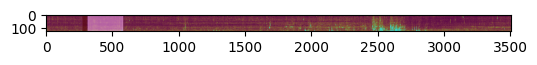

In [5]:
#Generates the dataset and test that it works with bounding boxes
import cv2
import pandas as pd
#dataset_dicts = get_balloon_dicts("monk/train")
home_dir = "/home/kenneb15"
annot = "annotations/"
annos_dir = "./annotations/"
#os.chdir(annos_dir)

dataset_dicts = get_annos("/root/annotations/train","/root/spectrogram/train")
print(len(dataset_dicts))
for d in random.sample(dataset_dicts, 1):
    test = d["file_name"]
    img = cv2.imread(test)
    visualizer = Visualizer(img[:, :, ::-1], metadata=call_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.rcParams['figure.dpi'] = 100
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
#Training hyperparameters and start training
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("monk_train",)
cfg.DATASETS.TEST = ()
#cfg.DATALOADER.NUM_WORKERS = 2
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

#Epochs = MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES

# minimum image size for the train set
cfg.INPUT.MIN_SIZE_TRAIN = (4000,)
# maximum image size for the train set
cfg.INPUT.MAX_SIZE_TRAIN = 7000
# minimum image size for the test set
cfg.INPUT.MIN_SIZE_TEST = 4000
# maximum image size for the test set
cfg.INPUT.MAX_SIZE_TEST = 7000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [51]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

/home/kenneb15/annotations/val


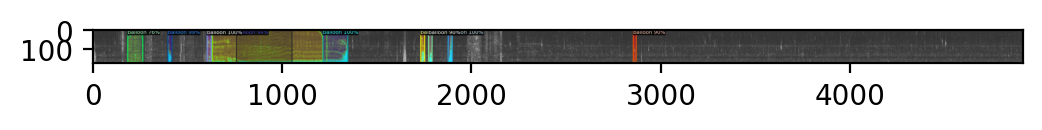

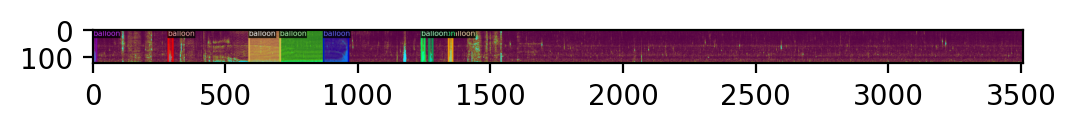

In [52]:
#Runs a test. Takes a random validation image and shows ground 
from detectron2.utils.visualizer import ColorMode
import random

#dataset_dicts = get_balloon_dicts("balloon/val")
dataset_dicts = get_annos("/home/kenneb15/annotations/val","/home/kenneb15/spectrogram/val")
random2 = random.sample(dataset_dicts, 3)
for d in random2:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.7, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.rcParams['figure.dpi'] = 200

    plt.imshow(out.get_image()[:, :, ::-1])
plt.show()
for d in random2:
    test = d["file_name"]
    img = cv2.imread(test)
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = visualizer.draw_dataset_dict(d)
    plt.rcParams['figure.dpi'] = 200
    plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [60]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("monk_val", output_dir="/home/kenneb15/annotations/val/output/output")
val_loader = build_detection_test_loader(cfg, "monk_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

# another equivalent way to evaluate the model is to use `trainer.test`

/home/kenneb15/annotations/val
[03/30 20:04:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(4000, 4000), max_size=7000, sample_style='choice')]
[03/30 20:04:04 d2.data.common]: Serializing 48 elements to byte tensors and concatenating them all ...
[03/30 20:04:04 d2.data.common]: Serialized dataset takes 0.05 MiB
[03/30 20:04:04 d2.evaluation.evaluator]: Start inference on 48 batches
[03/30 20:04:06 d2.evaluation.evaluator]: Inference done 11/48. Dataloading: 0.0844 s/iter. Inference: 0.0697 s/iter. Eval: 0.0128 s/iter. Total: 0.1670 s/iter. ETA=0:00:06
[03/30 20:04:11 d2.evaluation.evaluator]: Inference done 38/48. Dataloading: 0.0990 s/iter. Inference: 0.0686 s/iter. Eval: 0.0152 s/iter. Total: 0.1829 s/iter. ETA=0:00:01
[03/30 20:04:13 d2.evaluation.evaluator]: Total inference time: 0:00:07.968103 (0.185305 s / iter per device, on 1 devices)
[03/30 20:04:13 d2.evaluation.evaluator]: Total inference pure compute time

NameError: name 'model' is not defined

/home/kenneb15/annotations/val


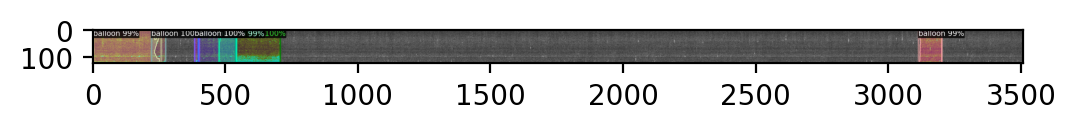

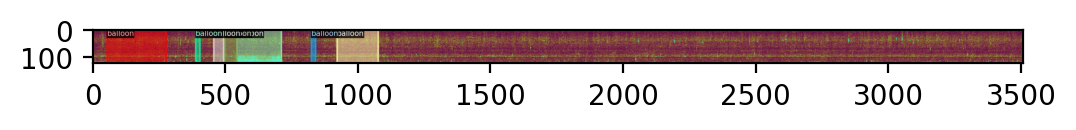

In [56]:
from detectron2.utils.visualizer import ColorMode
import random

#dataset_dicts = get_balloon_dicts("balloon/val")
dataset_dicts = get_annos("/home/kenneb15/annotations/val","/home/kenneb15/spectrogram/val")
random2 = random.sample(dataset_dicts, 3)
for d in random2:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
plt.show()
for d in random2:
    test = d["file_name"]
    img = cv2.imread(test)
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = visualizer.draw_dataset_dict(d)
    plt.rcParams['figure.dpi'] = 200
    plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [70]:
dir(evaluator.evaluate)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [11]:
torch.cuda.empty_cache()

In [87]:
torch.cuda.device_count()

2

In [71]:
print(device)

NameError: name 'device' is not defined

In [79]:
%%capture cap --no-stderr
import time
i = 0
while i < 50000:
    print(i)
    time.sleep(0.5)
    i = i+1

KeyboardInterrupt: 

In [80]:
cap.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
